### Import library

In [219]:
# display, transform, read, split ...
import numpy as np
import pandas as pd
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt
from glob import glob


# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,  array_to_img, img_to_array
# image augmentation
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

# Tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import nasnet

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
import tensorflow as tf

from IPython.display import Image
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [102]:
tf.__version__

'2.15.0'

## Train data pre-processing

#### Convert all images to .jpg and change all file name to sequential file name

Trained images were accquired from the internet by scraped technique. the name of imeages are random and not in order, and are not in same format.

For ease of processing, They will all be converted and changed name by creating function below.

Using picture_prep.ipynb to run pre-processing code

#### Prepare train data (image) to list of filename with directory

In [103]:
# Set up directories for train data
folder_path_amb = '../data/train_image/ambulance/'
files_amb = [f for f in os.listdir(folder_path_amb) if os.path.isfile(os.path.join(folder_path_amb, f))]

folder_path_cur = '../data/train_image/curtain/'
files_cur = [f for f in os.listdir(folder_path_cur) if os.path.isfile(os.path.join(folder_path_cur, f))]

# create a list of filenames
filenames_amb = []
for file in files_amb:
    filenames_amb.append(folder_path_amb+file)

filenames_cur = []
for file in files_cur:
    filenames_cur.append(folder_path_cur+file)



# Make a dataframe based on the filenames
df1 = pd.DataFrame(filenames_amb, columns = ["filename"])
df2 = pd.DataFrame(filenames_cur, columns = ["filename"])


# Add Class columns
df1['class'] = pd.Series([0 for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)



# Split into train and validation sets
train_set_percentage = .9


train_df1 = df1[:int(len(df1)*train_set_percentage)]
val_df1 = df1[int(len(df1)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]



df_new_train = pd.concat([train_df1, train_df2])
df_new_val = pd.concat([val_df1, val_df2])

# shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [104]:
print(df.shape)
print(df_val.shape)

(240, 2)
(27, 2)


In [105]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2

#### Create pipeline for train data loading and resize to 224x224

In [106]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  #image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [107]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

In [108]:
print(len(filenames))
print(len(val_filenames))

240
27


In [109]:
batch_size = 8
# Train data
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(32)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# Validation data
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(3)
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

## Modeling

#### The model will be train on VGG16 pre-trained model

In [110]:
# Call VGG16
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [111]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x) #Adaptive Pooling

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [112]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [113]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [114]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_5
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_4
True
dense_8
True
dense_9
True


In [115]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [116]:
# opt = tf.train.AdamOptimizer(learning_rate = 0.001)

opt = tf.keras.optimizers.Adam('learning_rate'==0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [117]:
train_steps = int(32) #total trains set / batch_size
val_steps = int(3)
epochs = 5

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 32
val steps: 3


In [118]:
# # # Train the model with validation
history = model.fit( train_dataset,
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/5
32/32 [==============================] - 45s 1s/step - loss: 1.2819 - accuracy: 0.6484 - val_loss: 1.0101 - val_accuracy: 0.5833
Epoch 2/5
32/32 [==============================] - 41s 1s/step - loss: 1.2967 - accuracy: 0.6406 - val_loss: 1.0101 - val_accuracy: 0.5833
Epoch 3/5
32/32 [==============================] - 41s 1s/step - loss: 1.3274 - accuracy: 0.6367 - val_loss: 1.0101 - val_accuracy: 0.5833
Epoch 4/5
32/32 [==============================] - 40s 1s/step - loss: 1.2934 - accuracy: 0.6406 - val_loss: 1.0101 - val_accuracy: 0.5833
Epoch 5/5
32/32 [==============================] - 40s 1s/step - loss: 1.2578 - accuracy: 0.6484 - val_loss: 1.0101 - val_accuracy: 0.5833


In [119]:
# Score
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 4s 1s/step - loss: 1.0101 - accuracy: 0.5833
model accuracy: 0.5833333134651184


## Test first model

Sample of test image 1:


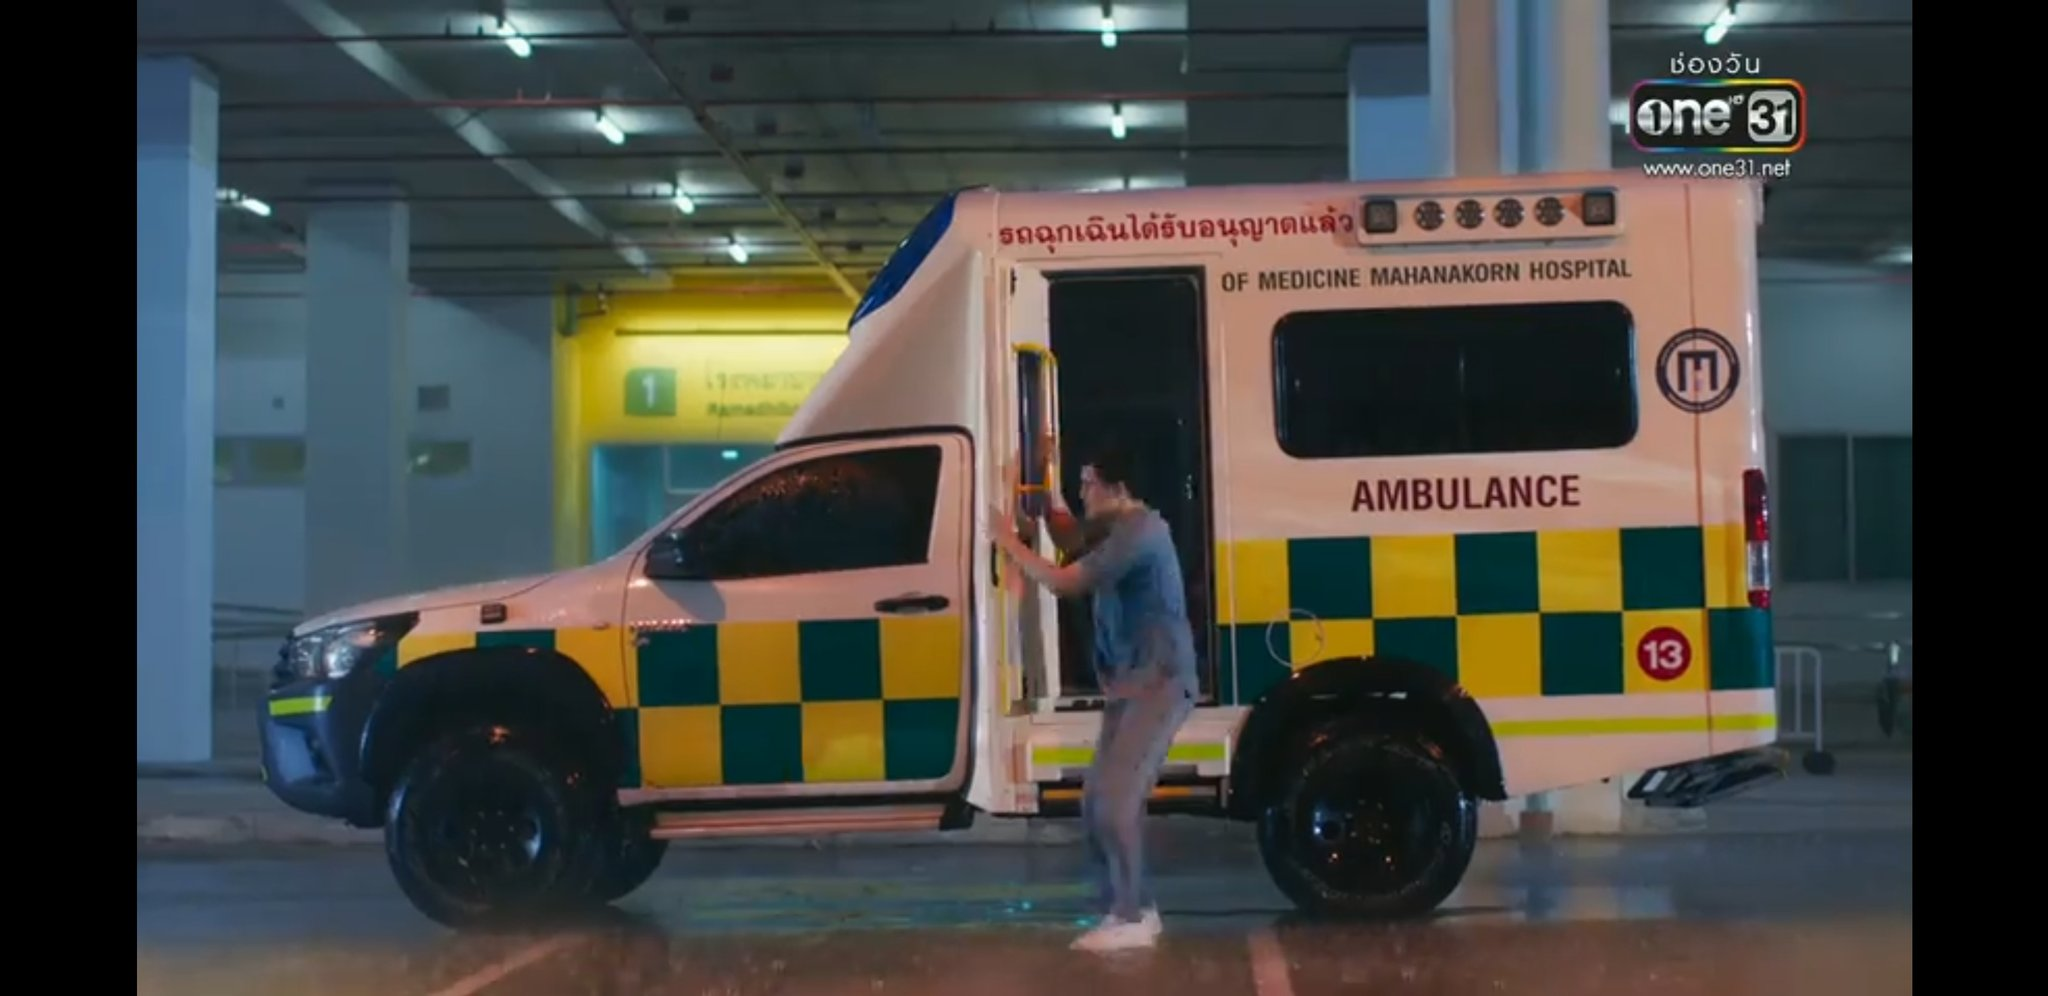

In [120]:
# Call test image for prediction
image_test_1 = '../data/test_image/1_amb.jpg'
image_test_2 = '../data/test_image/2_curtain.jpg'
image_test_3 = '../data/test_image/3_none.jpg'
image_test_4 = '../data/test_image/4_lisa.jpg'
filenames_test = [image_test_1, image_test_2, image_test_3, image_test_4]
print("Sample of test image 1:")
Image(image_test_1)

In [121]:
# Create list of file to run test
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [122]:
# Predict
preds = []
for x in x_test:
    preds.append(model.predict(x))

# Display result

for i in range(len(filenames_test)):
    print(filenames_test[i])
    if preds[i][0][0] > 0.9:
        print("It's an ambulance")
    else:
        print("None of them")


1/1 [==============================] - 0s 185ms/step
../data/test_image/1_amb.jpg
It's an ambulance
../data/test_image/2_curtain.jpg
It's an ambulance
../data/test_image/3_none.jpg
None of them
../data/test_image/4_lisa.jpg
It's an ambulance


### Accuracy and actual prediction isn't satisfy

-----

## Model improvement

### Consider expand the train dataset (and validation)

### Image augmentation

The selected image may appear in video in different angle, therefore the trained image should be in multiple angle and size
Using picture_prep.ipynb to run pre-processing code


Now, the data is 10 times larger due to augmentation of image. Let's feed these data to model and try again

In [123]:
# Set up directories for train data
folder_path_amb = '../data/train_image/augmented/ambulance/'
files_amb = [f for f in os.listdir(folder_path_amb) if os.path.isfile(os.path.join(folder_path_amb, f))]

folder_path_cur = '../data/train_image/augmented/curtain/'
files_cur = [f for f in os.listdir(folder_path_cur) if os.path.isfile(os.path.join(folder_path_cur, f))]

# create a list of filenames
filenames_amb = []
for file in files_amb:
    filenames_amb.append(folder_path_amb+file)

filenames_cur = []
for file in files_cur:
    filenames_cur.append(folder_path_cur+file)



# Make a dataframe based on the filenames
df1 = pd.DataFrame(filenames_amb, columns = ["filename"])
df2 = pd.DataFrame(filenames_cur, columns = ["filename"])


# Add Class columns
df1['class'] = pd.Series([0 for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)



# Split into train and validation sets
train_set_percentage = .9


train_df1 = df1[:int(len(df1)*train_set_percentage)]
val_df1 = df1[int(len(df1)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]



df_new_train = pd.concat([train_df1, train_df2])
df_new_val = pd.concat([val_df1, val_df2])

# shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2

batch_size = 8
# Train data
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(32)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# Validation data
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(3)
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [124]:
len(train_filenames_list)

13216

Re-compile the model for training

In [125]:
# Call VGG16
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x) #Adaptive Pooling

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [126]:
# opt = tf.train.AdamOptimizer(learning_rate = 0.001)

opt = tf.keras.optimizers.Adam('learning_rate'==0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [127]:
train_steps = int(100) #total trains set / batch_size
val_steps = int(10)
epochs = 20

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 100
val steps: 10


Use new dataset to train the existing model

In [128]:
# # # Train the model with validation
history = model.fit( train_dataset,
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/20
100/100 [==============================] - 132s 1s/step - loss: 1.5775 - accuracy: 0.4988 - val_loss: 1.4541 - val_accuracy: 0.5125
Epoch 2/20
100/100 [==============================] - 129s 1s/step - loss: 1.6531 - accuracy: 0.4787 - val_loss: 1.4541 - val_accuracy: 0.5125
Epoch 3/20
100/100 [==============================] - 127s 1s/step - loss: 1.5973 - accuracy: 0.4975 - val_loss: 1.4541 - val_accuracy: 0.5125
Epoch 4/20
100/100 [==============================] - 125s 1s/step - loss: 1.5775 - accuracy: 0.4988 - val_loss: 1.4541 - val_accuracy: 0.5125
Epoch 5/20
100/100 [==============================] - 127s 1s/step - loss: 1.6531 - accuracy: 0.4787 - val_loss: 1.4541 - val_accuracy: 0.5125
Epoch 6/20
100/100 [==============================] - 126s 1s/step - loss: 1.5973 - accuracy: 0.4975 - val_loss: 1.4541 - val_accuracy: 0.5125
Epoch 7/20
100/100 [==============================] - 139s 1s/step - loss: 1.5775 - accuracy: 0.4988 - val_loss: 1.4541 - val_accuracy: 0.5125

## Test 2nd time

Sample of test image 4:


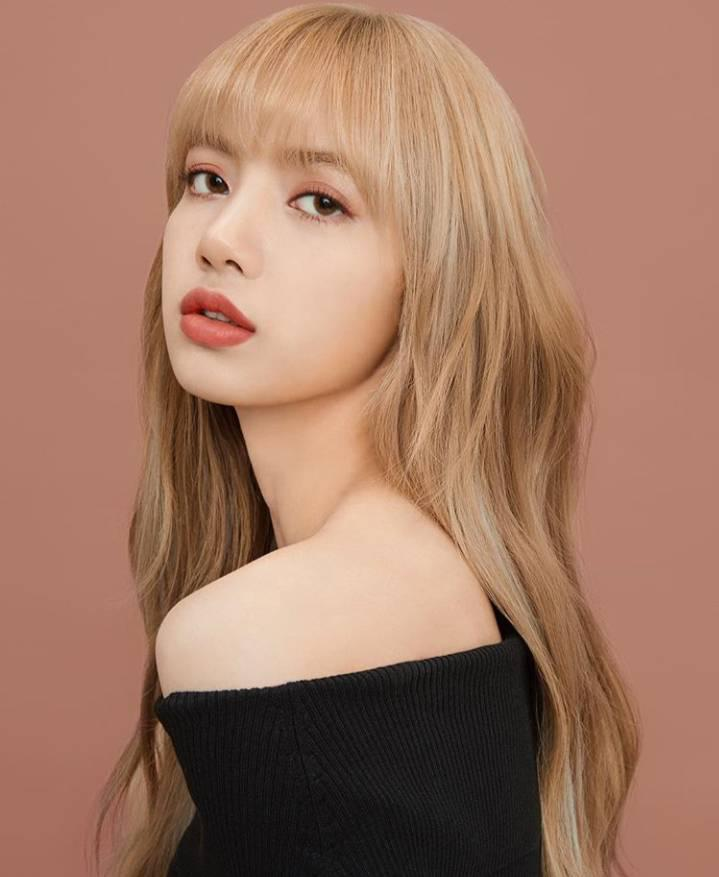

In [129]:
# Call test image for prediction
image_test_1 = '../data/test_image/1_amb.jpg'
image_test_2 = '../data/test_image/2_curtain.jpg'
image_test_3 = '../data/test_image/3_none.jpg'
image_test_4 = '../data/test_image/4_lisa.jpg'
filenames_test = [image_test_1, image_test_2, image_test_3, image_test_4]
print("Sample of test image 4:")
Image(image_test_4)

In [130]:
# Create list of file to run test
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [131]:
# Predict
preds = []
for x in x_test:
    preds.append(model.predict(x))

# Display result

for i in range(len(filenames_test)):
    print(filenames_test[i])
    if preds[i][0][0] > 0.9:
        print("It's an ambulance")
    else:
        print("None of them")

1/1 [==============================] - 0s 171ms/step
../data/test_image/1_amb.jpg
It's an ambulance
../data/test_image/2_curtain.jpg
It's an ambulance
../data/test_image/3_none.jpg
None of them
../data/test_image/4_lisa.jpg
None of them


### Model Fine-tuning

In [132]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:  
        layer.trainable = False

In [133]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_6
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
True
block5_conv2
True
block5_conv3
True
block5_pool
True
global_average_pooling2d_5
True
dense_10
True
dense_11
True


In [134]:
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 2,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/2
100/100 [==============================] - 130s 1s/step - loss: 1.5775 - accuracy: 0.4988 - val_loss: 1.4541 - val_accuracy: 0.5125
Epoch 2/2
100/100 [==============================] - 130s 1s/step - loss: 1.6531 - accuracy: 0.4787 - val_loss: 1.4541 - val_accuracy: 0.5125


In [135]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

10/10 [==============================] - 12s 1s/step - loss: 1.4541 - accuracy: 0.5125
model accuracy: 0.512499988079071


## Test 3rd time

Sample of test image 3:


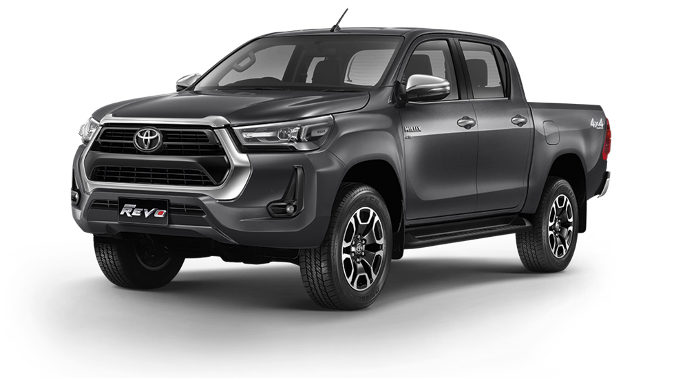

In [136]:
# Call test image for prediction
image_test_1 = '../data/test_image/1_amb.jpg'
image_test_2 = '../data/test_image/2_curtain.jpg'
image_test_3 = '../data/test_image/3_none.jpg'
image_test_4 = '../data/test_image/4_lisa.jpg'
filenames_test = [image_test_1, image_test_2, image_test_3, image_test_4]
print("Sample of test image 3:")
Image(image_test_3)

In [137]:
# Create list of file to run test
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [138]:
# Predict
preds = []
for x in x_test:
    preds.append(model.predict(x))

# Display result

for i in range(len(filenames_test)):
    print(filenames_test[i])
    if preds[i][0][0] > 0.9:
        print("It's an ambulance")
    else:
        print("None of them")

1/1 [==============================] - 0s 117ms/step
../data/test_image/1_amb.jpg
It's an ambulance
../data/test_image/2_curtain.jpg
It's an ambulance
../data/test_image/3_none.jpg
None of them
../data/test_image/4_lisa.jpg
None of them


---

## Demostration

For every second of the video, the model will identify whether it is "Ambulance" scene or "Emergency Room" scene or none of them

Using picture_prep.ipynb to run pre-processing code to convert target video into multiple pictures (number of pictures = duration in seconds of the video)

In [204]:
# Call test image for prediction
folder_path_test = '../data/test_data/test_set1/'
files_test = [f for f in os.listdir(folder_path_test) if os.path.isfile(os.path.join(folder_path_test, f))]
filenames_test = []
for file in files_test:
    filenames_test.append(folder_path_test+file)



In [205]:
# Create list of filenames for prediction
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [206]:
# Create list of predictions 0 = ambulance, 1 = emergency room
preds = []
for x in x_test:
    preds.append(model.predict(x))

1/1 [==============================] - 0s 120ms/step


In [207]:
# Convert integer to hour:minute:second
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [209]:
# to overcome sorting issue
def extract_number(file_name):
    return int(''.join(filter(str.isdigit, file_name)))

# create dataframe to store filenames and predictions
df = pd.DataFrame(filenames_test, columns = ["filename"])
df = df.iloc[df['filename'].map(extract_number).argsort()]
df['Seconds'] = pd.Series([x for x in range(len(filenames_test))], index=df.index) # Add seconds column
df['Minute-th'] = pd.Series([convert(x) for x in df['Seconds']], index=df.index) # add time column 
df['Ambulance'] = pd.Series([preds[x][0][0] for x in range(len(preds))], index=df.index) # Add prediction prob for ambulance
df['is_ambulance'] = np.where(df['Ambulance'] > 0.80, 1, 0)

df


,filename,Seconds,Minute-th,Ambulance,is_ambulance
0,../data/test_data/test_set1/1.jpg,0,0:00:00,0.181565,0
11,../data/test_data/test_set1/2.jpg,1,0:00:01,0.748857,0
22,../data/test_data/test_set1/3.jpg,2,0:00:02,0.919736,1
33,../data/test_data/test_set1/4.jpg,3,0:00:03,0.884909,1
42,../data/test_data/test_set1/5.jpg,4,0:00:04,0.252433,0
43,../data/test_data/test_set1/6.jpg,5,0:00:05,0.568016,0
44,../data/test_data/test_set1/7.jpg,6,0:00:06,0.782029,0
45,../data/test_data/test_set1/8.jpg,7,0:00:07,0.846995,1
46,../data/test_data/test_set1/9.jpg,8,0:00:08,0.685569,0
1,../data/test_data/test_set1/10.jpg,9,0:00:09,0.939121,1


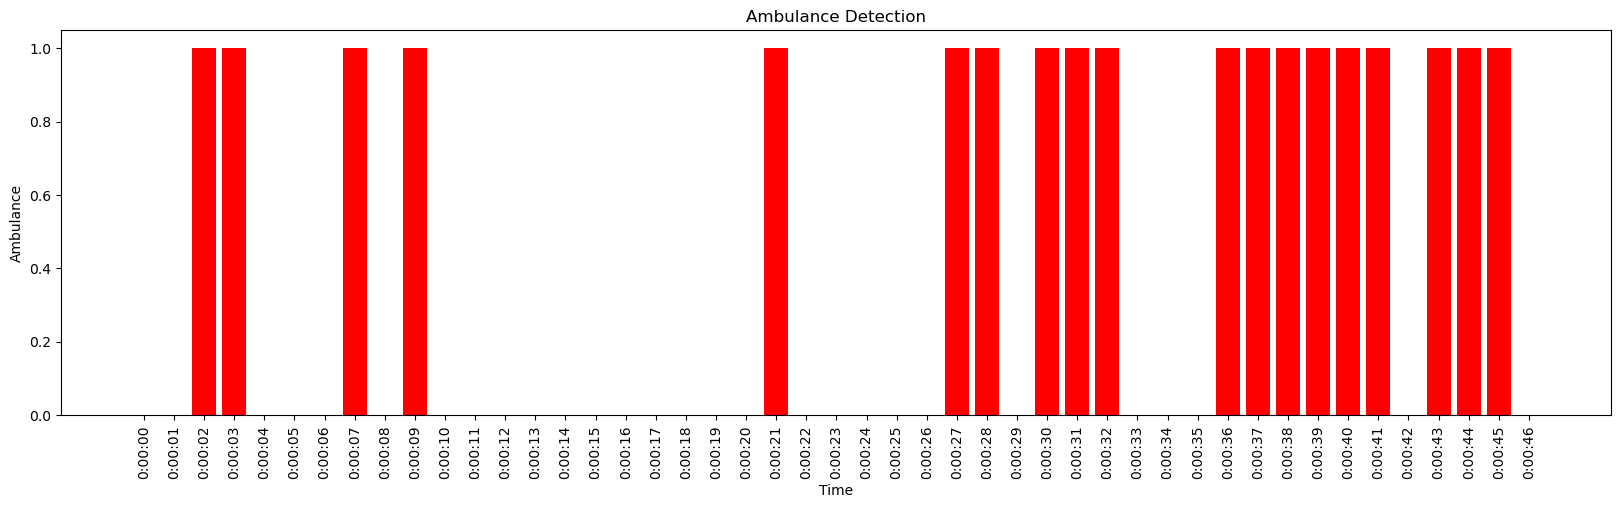

In [210]:
# Plot vertical bar chart where y is is_amblance and x is 'minute-th', x display every 5 seconds
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['is_ambulance'], color='red')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()



In [211]:
# Call test image for prediction for test video 2
folder_path_test = '../data/test_data/test_set2/'
files_test = [f for f in os.listdir(folder_path_test) if os.path.isfile(os.path.join(folder_path_test, f))]
filenames_test = []
for file in files_test:
    filenames_test.append(folder_path_test+file)


In [212]:
# Create list of filenames for prediction
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [213]:
# Create list of predictions 0 = ambulance, 1 = emergency room
preds = []
for x in x_test:
    preds.append(model.predict(x))

1/1 [==============================] - 0s 131ms/step


In [217]:
# to overcome sorting issue
def extract_number(file_name):
    return int(''.join(filter(str.isdigit, file_name)))

# create dataframe to store filenames and predictions
df = pd.DataFrame(filenames_test, columns = ["filename"])
df = df.iloc[df['filename'].map(extract_number).argsort()]
df['Seconds'] = pd.Series([x for x in range(len(filenames_test))], index=df.index) # Add seconds column
df['Minute-th'] = pd.Series([convert(x) for x in df['Seconds']], index=df.index) # add time column 
df['Ambulance'] = pd.Series([preds[x][0][0] for x in range(len(preds))], index=df.index) # Add prediction prob for ambulance
df['is_ambulance'] = np.where(df['Ambulance'] > 0.999, 1, 0)
df

,filename,Seconds,Minute-th,Ambulance,is_ambulance
0,../data/test_data/test_set2/1.jpg,0,0:00:00,0.996563,0
11,../data/test_data/test_set2/2.jpg,1,0:00:01,0.990674,0
22,../data/test_data/test_set2/3.jpg,2,0:00:02,0.389534,0
30,../data/test_data/test_set2/4.jpg,3,0:00:03,0.279267,0
31,../data/test_data/test_set2/5.jpg,4,0:00:04,0.025594,0
32,../data/test_data/test_set2/6.jpg,5,0:00:05,0.062149,0
33,../data/test_data/test_set2/7.jpg,6,0:00:06,0.529352,0
34,../data/test_data/test_set2/8.jpg,7,0:00:07,0.616352,0
35,../data/test_data/test_set2/9.jpg,8,0:00:08,0.720609,0
1,../data/test_data/test_set2/10.jpg,9,0:00:09,0.942851,0


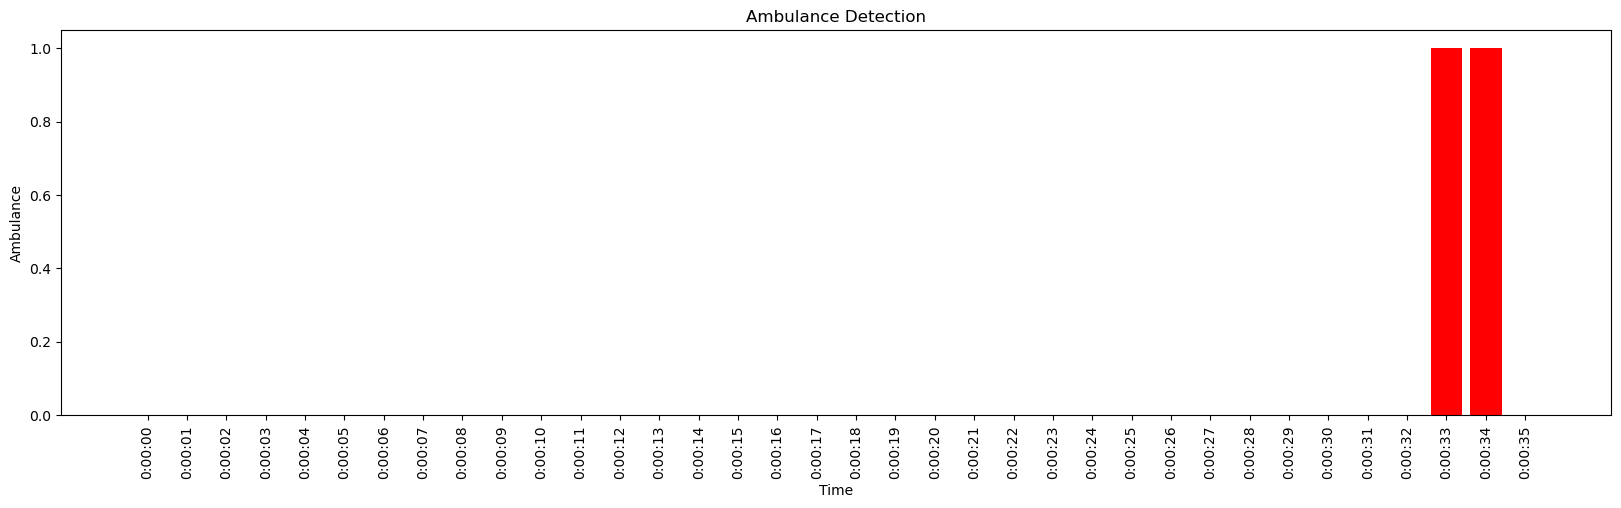

In [218]:
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['is_ambulance'], color='red')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()